# PROJECT: KMeans Clustering of Rabindranath Tagore and Salil Chowdhury

This experiment attempts to group the music of two composers - Rabindranath Tagore and Salil Chowdhury - into 2 clusters. The music data is collected from [here](https://cse.iitkgp.ac.in/~abhij/mus/index.html) in midi format. KMeans clustering technique that utilizes euclidian distance between the datapoints to create the assigned number of clusters is used. 

In [ ]:
from music21 import converter, instrument, note, chord, stream, midi
import glob
import os
import time
import numpy as np
import torch
import pandas
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import itertools

The first step is to create a representative array of numerical data so that the music can be fed into the clustering algorithm. The method to transform the midi data into numpy array has been taken from this [colab notebook](https://colab.research.google.com/github/cpmpercussion/creative-prediction/blob/master/notebooks/3-zeldic-musical-RNN.ipynb#scrollTo=EGQKAczzQLft).

In [ ]:
# Method for converting midi file to a numpy array [Ref. 1]

# Melody-RNN Format is a sequence of 8-bit integers indicating the following:
# MELODY_NOTE_ON = [0, 127] # (note on at that MIDI pitch)
MELODY_NOTE_OFF = 128 # (stop playing all previous notes)
MELODY_NO_EVENT = 129 # (no change from previous event)
# Each element in the sequence lasts for one sixteenth note.
# This can encode monophonic music only.

def streamToNoteArray(stream):
    """
    Convert a Music21 sequence to a numpy array of int8s into Melody-RNN format:
        0-127 - note on at specified pitch
        128   - note off
        129   - no event
    """
    # Part one, extract from stream
    total_length = np.int(np.round(stream.flat.highestTime / 0.25)) # in semiquavers
    stream_list = []
    for element in stream.flat:
        if isinstance(element, note.Note):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.pitch.midi])
        elif isinstance(element, chord.Chord):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.sortAscending().pitches[-1].midi])
    np_stream_list = np.array(stream_list, dtype=np.int)
    df = pandas.DataFrame({'pos': np_stream_list.T[0], 'dur': np_stream_list.T[1], 'pitch': np_stream_list.T[2]})
    df = df.sort_values(['pos','pitch'], ascending=[True, False]) # sort the dataframe properly
    df = df.drop_duplicates(subset=['pos']) # drop duplicate values
    # part 2, convert into a sequence of note events
    output = np.zeros(total_length+1, dtype=np.int16) + np.int16(MELODY_NO_EVENT)  # set array full of no events by default.
    # Fill in the output list
    for i in range(total_length):
        if not df[df.pos==i].empty:
            n = df[df.pos==i].iloc[0] # pick the highest pitch at each semiquaver
            output[i] = n.pitch # set note on
            output[i+n.dur] = MELODY_NOTE_OFF
    return output

In [ ]:
# Create dataset to feed into clustering algorithm

salil_path = '/content/drive/MyDrive/Music/salil/*.mid'
rabindranath_path = '/content/drive/MyDrive/Music/rabindranath/*.mid'

target_code = {'salil': 0, 
               'rabindranath': 1}

train_data = []
lengths = []

for s, r in zip(glob.iglob(salil_path), glob.iglob(rabindranath_path)):
    s_array = streamToNoteArray(converter.parse(s))
    s_target = target_code[s.split('/')[-2]]
    r_array = streamToNoteArray(converter.parse(r))
    r_target = target_code[r.split('/')[-2]]
    lengths.extend([len(s_array), len(r_array)])
    train_data.extend([(s_array, s_target, os.path.basename(s)[:-4]), (r_array, r_target, os.path.basename(r)[:-4])])

# Randomly shuffle the samples

random.shuffle(train_data)

# Find the minium length of the samples

min_length = min(lengths)

# Separate class category of the samples in the dataset and take all samples 
# up to the minimum length

X = np.vstack([data[0][:min_length] for data in train_data])
T = np.array([data[1] for data in train_data])
names = np.array([data[2] for data in train_data])

# Print X and T shape

print(f'Input sample matrix shape: {X.shape}')
print(f'Target class matrix shape: {T.shape}')

Input sample matrix shape: (20, 740)
Target class matrix shape: (20,)


The input set is a matrix of shape (20 x 740), where the number of music samples is 20. The music of Rabindranath Tagore is labeled as 1 and Salil Chowdhury's music is labeled as 0. Each class has 10 samples. Since the music length varies case by case, the minimum length from the input array samples, which is 740, is taken to represent all the compositions. The name of the compositions are shown here.

In [ ]:
# The name of the compositions to be clustered

names

array(['jedin_sokol_mukul', 'keno_pantho_e_choncholota',
       'ay_bristi_jhnepe', 'je_ratey_mor',
       'amar_bhuban_to_aj_holo_kangal', 'ami_tomay_joto', 'o_projapoti',
       'ke_jabi_ay', 'monay_robey_ki_na_robey', 'chompaboti',
       'chonchol_sonali', 'jhilik_jhilik', 'aji_bijano_ghorey',
       'pallabini_go', 'prantorero_gan', 'o_majhi_bhaiyo',
       'orey_sabdhani_pothik', 'ami_cholte_cholte', 'dujoney_dekha_holo',
       'amar_ei_path_chawatei_anondo'], dtype='<U29')

From the next two code cells it is observed that KMeans clustering results in 60% accuracy with both raw data and standardized data, which is a little above the random chance. That means there might be some pattern in the data that can be explained with Euclidean distance between the data points. But of course, there are more to the compositions.

In [ ]:
# K-means clustering of the raw sample arrays (w/o standardization)

kmeans = KMeans(n_clusters=2, random_state=10)
pred_labels = kmeans.fit_predict(X)
print(f'Clustering (w/o standardization) accuracy: {len(np.where(pred_labels == T)[0])/len(T)}')

Clustering (w/o standardization) accuracy: 0.6


In [ ]:
# K-means clustering of the raw sample arrays (with standardization)

X_std = (X - X.mean())/X.std()
kmeans = KMeans(n_clusters=2, random_state=10)
pred_labels = kmeans.fit_predict(X_std)
print(f'Clustering (with standardization) accuracy: {len(np.where(pred_labels == T)[0])/len(T)}')

Clustering (with standardization) accuracy: 0.6


Silhoutte score: -0.00339749536178105


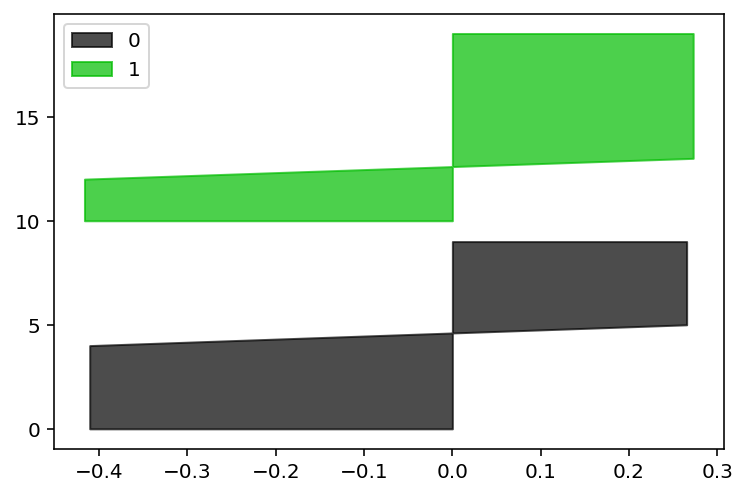

In [ ]:
# Silhoutte score

print(f'Silhoutte score: {silhouette_score(T.reshape(-1, 1), pred_labels)}')

# Plot Silhoutte score

n_clusters = 2
fig, ax1 = plt.subplots(1, 1)
s_sil = silhouette_samples(T.reshape(-1, 1), pred_labels)
for i in [0, 1]:
    sil_t = s_sil[T == i]
    sil_t.sort()
    y_lower = i*len(sil_t)
    y_upper = y_lower + len(sil_t)
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, sil_t,
                      facecolor=color, edgecolor=color, alpha=0.7, label = i)
    ax1.set_yticks(list(range(0, 20, 5)))
    ax1.legend(loc = "upper left")

Elbow method does not give any clear idea about the optimal number of clusters for this dataset.

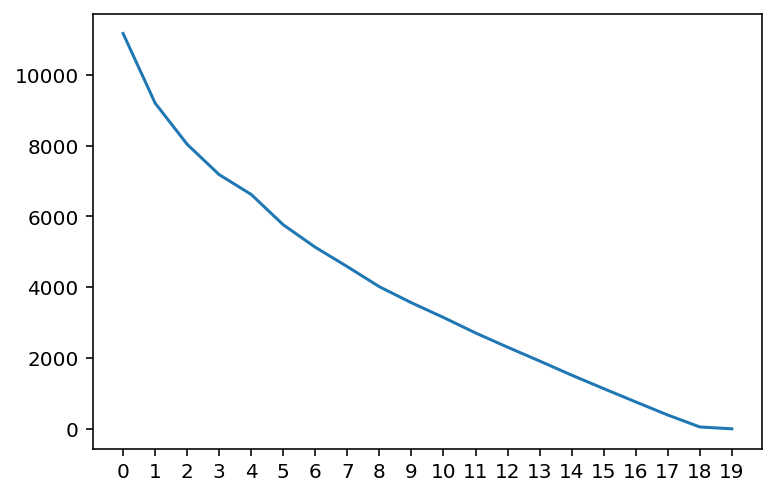

In [ ]:
# Elbow method to observe optimal cluster number

wcss_score = []
n_clusters = 20
seed = 10
X_std = (X - X.mean())/X.std()
for c in range(n_clusters):
    kmeans = KMeans(n_clusters=c+1, init="k-means++", random_state=seed)
    kmeans.fit(X_std)
    wcss_score.append(kmeans.inertia_)
plt.xticks(list(range(20)))
plt.plot(wcss_score);

## Dimensionality Reduction with PCA and TSNE

Since 740 features for each compositions makes it a high dimensional problem, the next thing tried was to reduce the dimension using either Principal Component Analysis (PCA) or T-distributed Stochastic Neighbor Embedding (TSNE). PCA with 3 components is first examined, where the elbow methods shows 4 as the optimal number of clusters. 

[0.19547417 0.1031013  0.09385863]


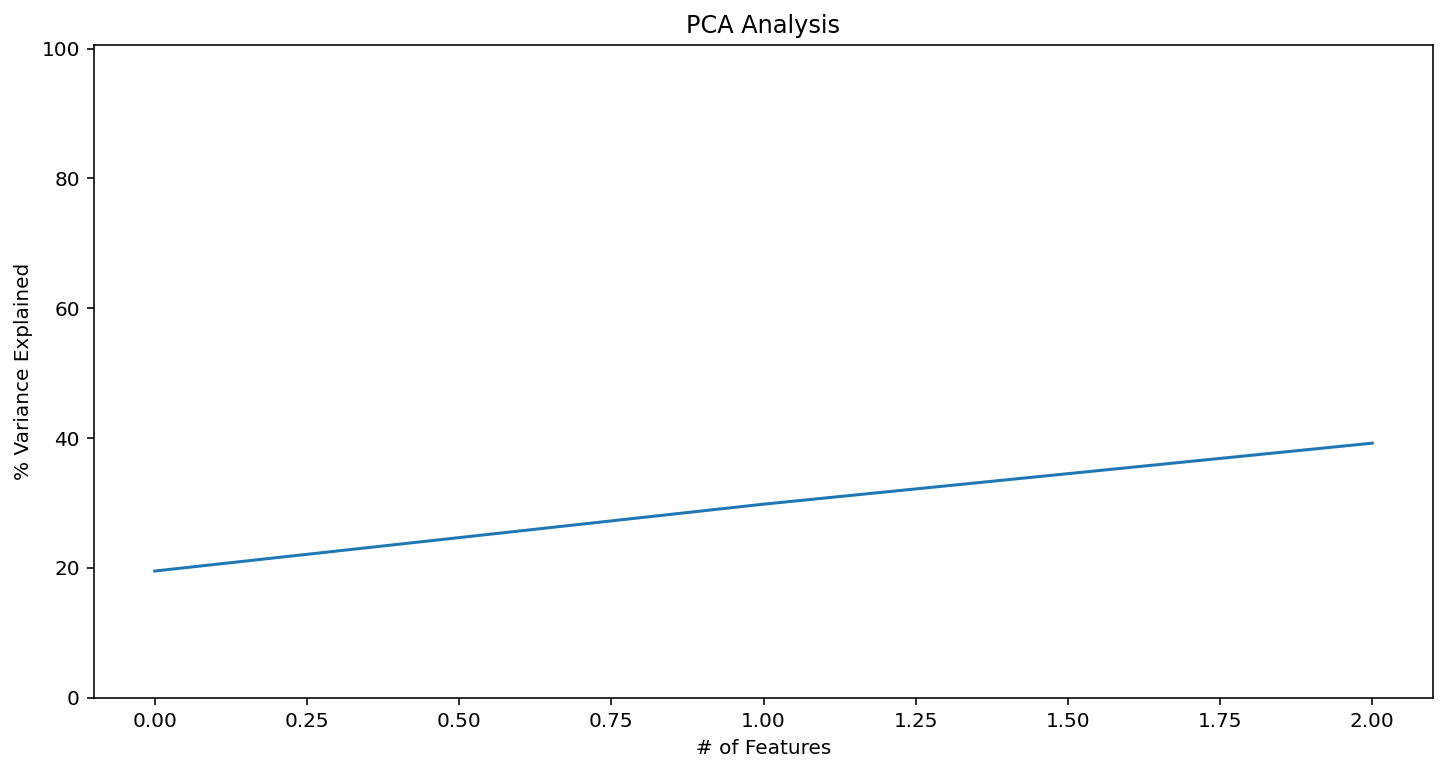

In [ ]:
# Reduce the high number of features in the input sample to 3 principal 
# components each capturing independent (non-correlated) variance of the 
# actual input features

X_std = (X - X.mean())/X.std()
pca = PCA(n_components=3)
pca_model = pca.fit(X_std)
X_pca = pca_model.transform(X_std)

# Plot variance captured by the PCs

print(pca.explained_variance_ratio_)

variance = pca_model.explained_variance_ratio_
var = np.cumsum(np.round(variance, 3)*100)
plt.figure(figsize=(12,6))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.plot(var);

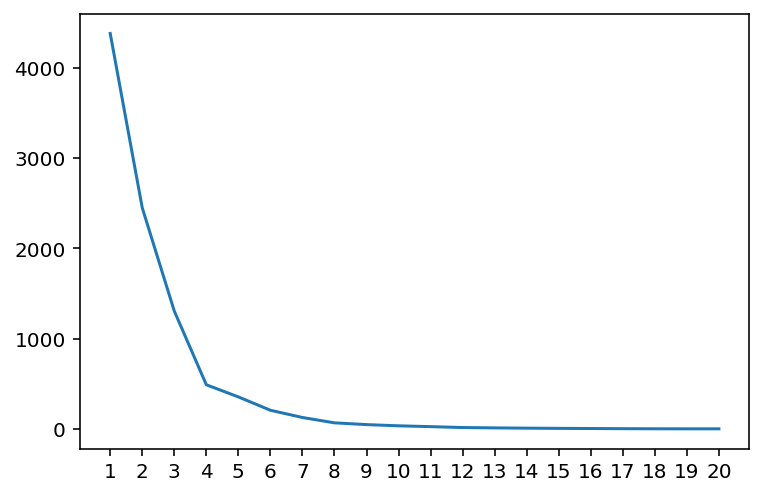

In [ ]:
# Elbow method with PCs

fig, ax1 = plt.subplots(1, 1)
wcss_score = []
n_clusters = 20
seed = 10
for c in range(n_clusters):
    kmeans = KMeans(n_clusters=c+1, init="k-means++", random_state=seed)
    kmeans.fit(X_pca)
    wcss_score.append(kmeans.inertia_)
ax1.set_xticks(list(range(1, 21)))
ax1.plot(list(range(1, 21)), wcss_score);

Let's now visualize 3 separate scatter plots of 1, 2, and 3 Principal Components. Plot with only the first PC does not show any obvious cluster pattern. But the plot with first 2 PCs does group some of the points into a cluster. Plot with all 3 PCs also shows similar cluster pattern as the one with 2 PCs.

In [ ]:
# Convert PC array to a pandas dataframe
df = pandas.DataFrame(X_pca, columns = ['PC1','PC2','PC3'])

# Add 'Class' column for representing the actual (ground-truth) category 
# of the samples
df['Class'] = T.reshape(-1, 1)
df['Name'] = names.reshape(-1, 1)

# Add 'color' column specifyin color for each cluster class for visualization
colors = ['#DF2020', '#81DF20']
df['color'] = df.Class.map({0: colors[0], 1: colors[1]})
df

,PC1,PC2,PC3,Class,Name,color
0,-9.801355,-4.228245,1.035313,1,jedin_sokol_mukul,#81DF20
1,12.019717,4.779170,-16.469264,1,keno_pantho_e_choncholota,#81DF20
2,7.417110,12.196906,17.313471,0,ay_bristi_jhnepe,#DF2020
3,-8.859115,-2.499315,-0.566492,1,je_ratey_mor,#81DF20
4,1.264126,6.291802,-4.609370,1,amar_bhuban_to_aj_holo_kangal,#81DF20
5,-9.698471,-2.359518,-1.782833,1,ami_tomay_joto,#81DF20
6,-9.318304,0.925683,-0.877911,0,o_projapoti,#DF2020
7,-5.870003,-0.619340,-0.291619,0,ke_jabi_ay,#DF2020
8,12.216980,4.824038,-16.324826,1,monay_robey_ki_na_robey,#81DF20
9,17.691182,-10.398287,2.760627,0,chompaboti,#DF2020


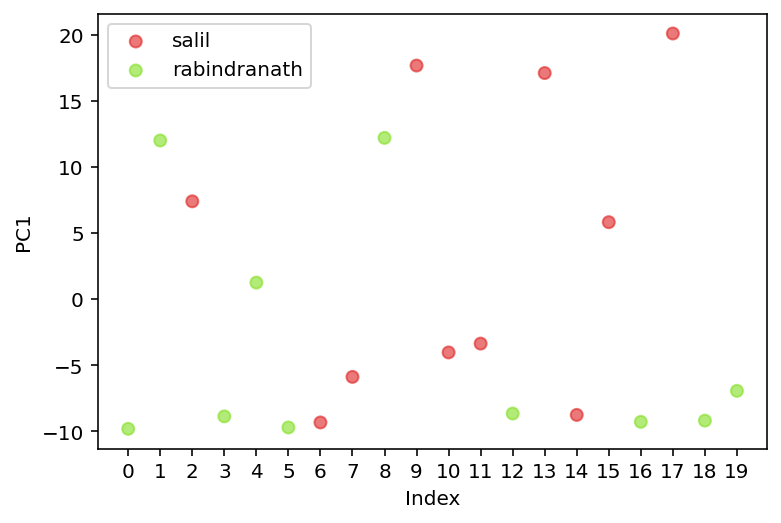

In [ ]:
# Scatter plot of first PC

c_labels = ['salil', 'rabindranath']
for col, l in zip(colors, c_labels):
  dfc = df[df.color == col]
  plt.scatter(dfc.index, dfc.PC1, c=dfc.color, alpha=0.6, label = l)
plt.xticks(list(range(20)))
plt.xlabel('Index')
plt.ylabel('PC1')
plt.legend();

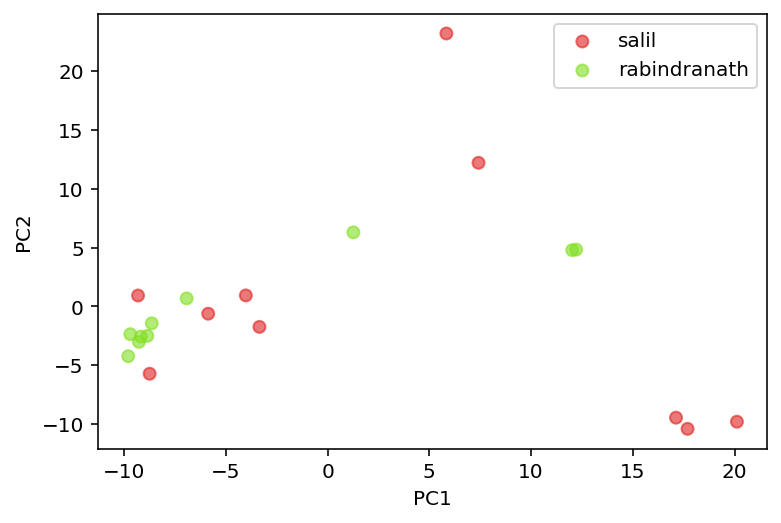

In [ ]:
# Scatter plot of first 2 PCs

c_labels = ['salil', 'rabindranath']
for col, l in zip(colors, c_labels):
    dfc = df[df.color == col]
    plt.scatter(dfc.PC1, dfc.PC2, c=dfc.color, alpha=0.6, label = l)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend();

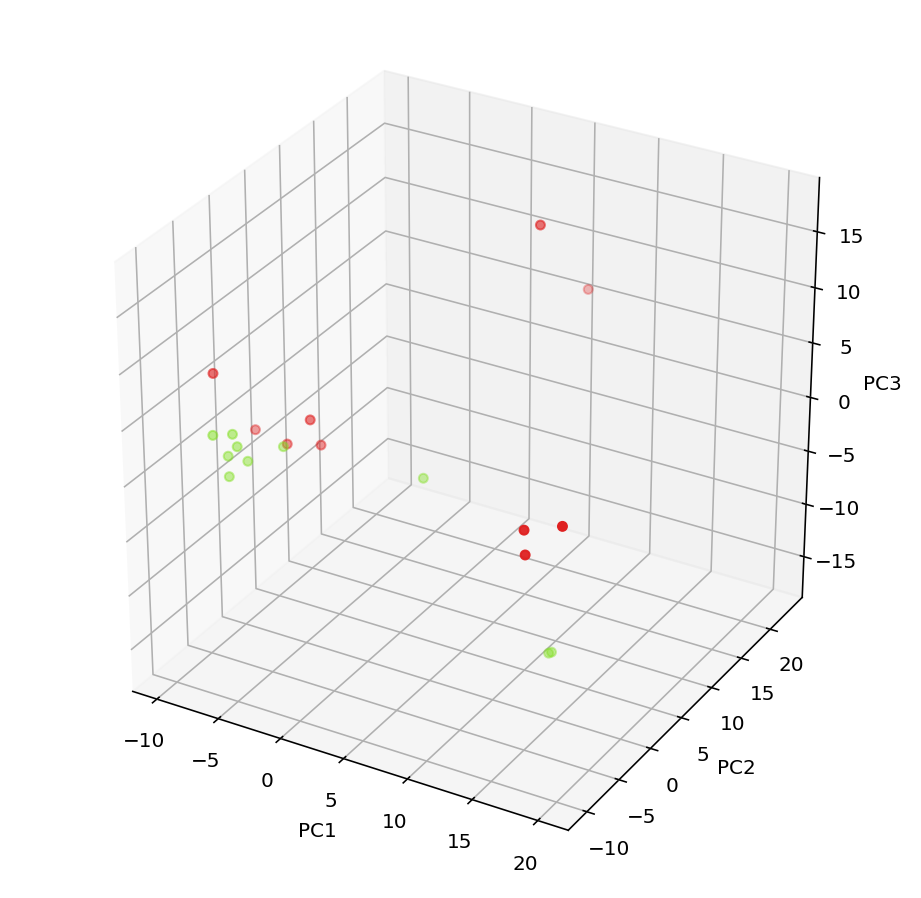

In [ ]:
# Scatter plot of 3 PCs

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.PC1, df.PC2, df.PC3, c=df.color)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show();

Here we try to see the clustering accuracy for all the combinations of the PCs and the models with PC1 and combination of (PC1, PC3) show the highest accuracy of 65%. 

In [ ]:
# K-means clustering with different combinations of PCs and create 'cluster' column for the predicted labels

PC_list = ['PC1', 'PC2', 'PC3']

for i in range(1, 4, 1):
    pcs_comb = list(itertools.combinations(PC_list, i))
    for pcs in pcs_comb:
        kmeans = KMeans(n_clusters=2, random_state=10)
        labels = kmeans.fit_predict(df[list(pcs)])
        df['cluster'] = labels

        print(f'Clustering accuracy with {pcs}: {len(np.where(T == labels)[0])/len(T)}')

Clustering accuracy with ('PC1',): 0.65
Clustering accuracy with ('PC2',): 0.55
Clustering accuracy with ('PC3',): 0.6
Clustering accuracy with ('PC1', 'PC2'): 0.4
Clustering accuracy with ('PC1', 'PC3'): 0.65
Clustering accuracy with ('PC2', 'PC3'): 0.4
Clustering accuracy with ('PC1', 'PC2', 'PC3'): 0.35


The 2 clusters formed by feeding PC1 and PC3 into KMeans clustering algorithm are plotted below. Some samples are placed in the wrong cluster with this approach. The silhoutte score shows improvement in results. 

In [ ]:
# For better visualization let us consider the PC1 and PC3 combination for clustering

kmeans = KMeans(n_clusters=2, random_state=10)
labels = kmeans.fit_predict(df[['PC1', 'PC3']])
df['cluster'] = labels

print(f'Clustering accuracy with PC1 and PC3: {len(np.where(T == labels)[0])/len(T)}')

Clustering accuracy with PC1 and PC3: 0.65


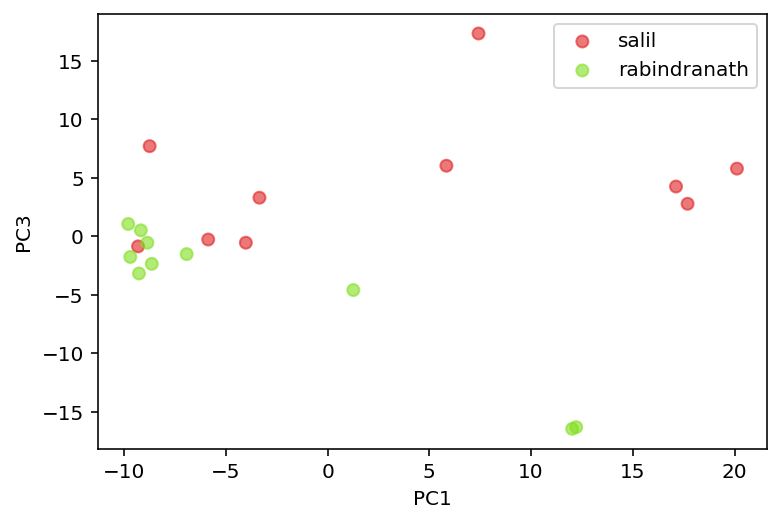

In [ ]:
# Scatter plot of PC1 and PC3

c_labels = ['salil', 'rabindranath']
for col, l in zip(colors, c_labels):
    dfc = df[df.color == col]
    plt.scatter(dfc.PC1, dfc.PC3, c=dfc.color, alpha=0.6, label = l)
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.legend();

In [ ]:
# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
## add to df
df['cen_x'] = df.cluster.map({0:cen_x[0], 1:cen_x[1]})
df['cen_y'] = df.cluster.map({0:cen_y[0], 1:cen_y[1]})
df

,PC1,PC2,PC3,Class,Name,color,cluster,cen_x,cen_y
0,-9.801355,-4.228245,1.035313,1,jedin_sokol_mukul,#81DF20,1,-7.109545,-0.253621
1,12.019717,4.779170,-16.469264,1,keno_pantho_e_choncholota,#81DF20,0,13.203440,0.471011
2,7.417110,12.196906,17.313471,0,ay_bristi_jhnepe,#DF2020,0,13.203440,0.471011
3,-8.859115,-2.499315,-0.566492,1,je_ratey_mor,#81DF20,1,-7.109545,-0.253621
4,1.264126,6.291802,-4.609370,1,amar_bhuban_to_aj_holo_kangal,#81DF20,1,-7.109545,-0.253621
5,-9.698471,-2.359518,-1.782833,1,ami_tomay_joto,#81DF20,1,-7.109545,-0.253621
6,-9.318304,0.925683,-0.877911,0,o_projapoti,#DF2020,1,-7.109545,-0.253621
7,-5.870003,-0.619340,-0.291619,0,ke_jabi_ay,#DF2020,1,-7.109545,-0.253621
8,12.216980,4.824038,-16.324826,1,monay_robey_ki_na_robey,#81DF20,0,13.203440,0.471011
9,17.691182,-10.398287,2.760627,0,chompaboti,#DF2020,0,13.203440,0.471011


(-22.0, 30.0)

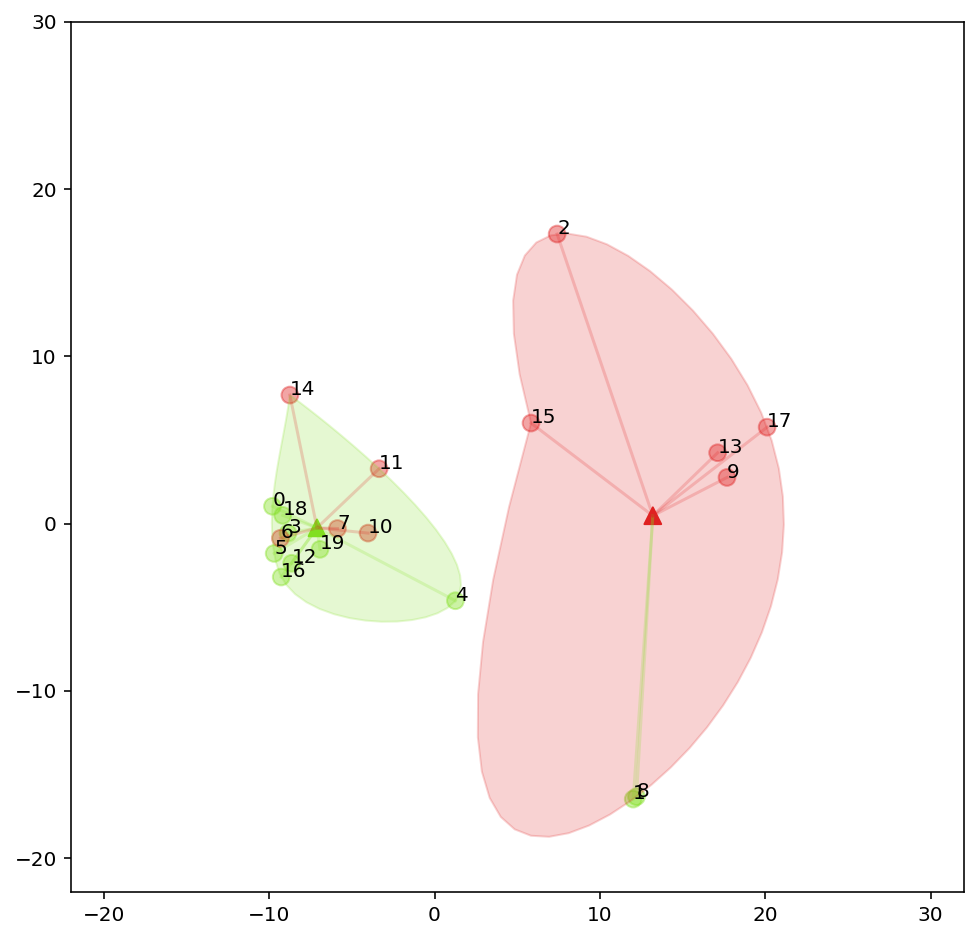

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,8))
plt.scatter(df.PC1, df.PC3, c=df.color, alpha = 0.4, s = 70)
plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)

# plot lines
for idx, val in df.iterrows():
    x = [val.PC1, val.cen_x,]
    y = [val.PC3, val.cen_y]
    plt.plot(x, y, c=val.color, alpha=0.2)
    ax.annotate(idx, (val.PC1, val.PC3))

for i in df.cluster.unique():
    # get the convex hull
    points = df[df.cluster == i][['PC1', 'PC3']].values
    hull = ConvexHull(points)
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    
    # interpolate
    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], 
                                    u=dist_along, s=0)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)
    # plot shape
    plt.fill(interp_x, interp_y, '--', c=colors[i], alpha=0.2)
    
plt.xlim(-22,32)
plt.ylim(-22,30)

It looks like PC1 and PC3 are capable of capturing the compositions of Rabindranath Tagore better as the corresponding data points are more packed together compared to those of Salil Chowdhury. The area of Salil Chowdhury is more spread and some of the compositions are even placed very near to Tagore's cluster. 

Silhoutte score: 0.08454670329670329


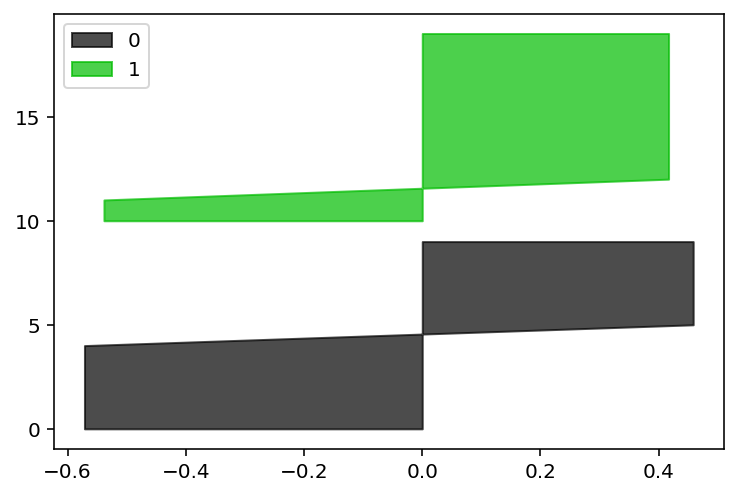

In [ ]:
# Improved Silhoutte score

print(f'Silhoutte score: {silhouette_score(T.reshape(-1, 1), labels)}')

# Plot Silhoutte score

fig, ax1 = plt.subplots(1, 1)
s_sil = silhouette_samples(T.reshape(-1, 1), labels)
n_clusters = 2
for i in [0, 1]:
    sil_t = s_sil[T == i]
    sil_t.sort()
    y_lower = i*len(sil_t)
    y_upper = y_lower + len(sil_t)
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, sil_t,
                      facecolor=color, edgecolor=color, alpha=0.7, label = i)
    ax1.set_yticks(list(range(0, 20, 5)))
    ax1.legend(loc = "upper left")

The misclusterd samples are shows in the dataframe below.

In [ ]:
# Songs that are assigned in the wrong cluster

df[df['Class'] != df['cluster']]

,PC1,PC2,PC3,Class,Name,color,cluster,cen_x,cen_y
1,12.019717,4.779170,-16.469264,1,keno_pantho_e_choncholota,#81DF20,0,13.203440,0.471011
6,-9.318304,0.925683,-0.877911,0,o_projapoti,#DF2020,1,-7.109545,-0.253621
7,-5.870003,-0.619340,-0.291619,0,ke_jabi_ay,#DF2020,1,-7.109545,-0.253621
8,12.216980,4.824038,-16.324826,1,monay_robey_ki_na_robey,#81DF20,0,13.203440,0.471011
10,-4.019795,0.934477,-0.565781,0,chonchol_sonali,#DF2020,1,-7.109545,-0.253621
11,-3.351292,-1.739489,3.280688,0,jhilik_jhilik,#DF2020,1,-7.109545,-0.253621
14,-8.747786,-5.717249,7.686806,0,prantorero_gan,#DF2020,1,-7.109545,-0.253621


Clustering with TSNE does not seem to produce above chance accuracy. 

In [ ]:
# TSNE

X_std = (X - X.mean())/X.std()
tsne_model = TSNE(n_components=3, verbose=1, perplexity=80, n_iter=5000, learning_rate=200)
X_tsne = tsne_model.fit_transform(X_std)

kmeans = KMeans(n_clusters=2, random_state=10)
labels = kmeans.fit_predict(X_tsne[:, [1, 2]])

print(f'TSNE clustering accuracy: {len(np.where(T == labels)[0])/len(T)}')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.000s...
[t-SNE] Computed neighbors for 20 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.856716
[t-SNE] KL divergence after 5000 iterations: 0.449644
TSNE clustering accuracy: 0.5


# References:

1. https://colab.research.google.com/github/cpmpercussion/creative-prediction/blob/master/notebooks/3-zeldic-musical-RNN.ipynb#scrollTo=EGQKAczzQLft

2. https://cse.iitkgp.ac.in/~abhij/mus/index.html

3. https://www.kaggle.com/abhishekyadav5/kmeans-clustering-with-elbow-method-and-silhouette

4. https://towardsdatascience.com/visualizing-clusters-with-pythons-matplolib-35ae03d87489

5. https://towardsdatascience.com/explaining-k-means-clustering-5298dc47bad6